Note -> This file is exact same file from 05_0_PyTorch_Custom_Datasets, but in this folder, I will try extracting functions that are used often as .py scripts.

We can use the jupyter notebook magic command -> 

## `%%writefile`

# Custom Datasets -> 

### What is a custom dataset?

There are multiple domain libraries like 
- TorchVision
- TorchAudio
- TorchText
- TorchRec
- TorchData

All these different domains have different functions inside them, For various functionality.


For getting my own data into PyTorch, We use custom datasets.

In [126]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

torch.__version__

'2.4.0+cu124'

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

### Getting the data ->

**Food101** has 101 categories of foods, With 1000 Images per Food(750-250 as Training-Testing split)

As first time trying, Will use a subset of this dataset with 3 categories, and 10% of Images in same proportions.

Later after experimentation will scale it up :)

In [128]:
import requests
import zipfile

#Setting up the path and folder -> 

from pathlib import Path
datapath= Path("data")
image_path=datapath/"pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} already exists.")
    
else:
    print(f"{image_path} does not exist, Creating directory...")
    image_path.mkdir(parents=True,exist_ok=True) 
    


    #Downloading custom data subset from github -> 

    with open(datapath/"pizza_steak_sushi.zip","wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading the data!")
        f.write(request.content)
        f.close()
        
    #Extracting/Unzipping the data ->

    with zipfile.ZipFile(datapath/"pizza_steak_sushi.zip","r") as zip_ref:
        print("Unzipping the data!")    
        zip_ref.extractall(image_path)
        zip_ref.close()

data\pizza_steak_sushi already exists.


### Data Preparation and Exploration -> 

In [129]:
import os

def walk_through_dir(dir_path):
    #Walks through the dir_path returning its contents
    
    for dirpath,dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")
    
    
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'


In [130]:
train_dir = image_path/"train" 
test_dir = image_path/"test"  


train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

#### Visualising a random image -> 

Lets write some code to:
1. Get all of the image paths. 
2. Pick a random image path using python's `random.choice()`
3. Get an image class name using `pathlib.Path.parent.stem`
4. Opening the image with Python's PIL


Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


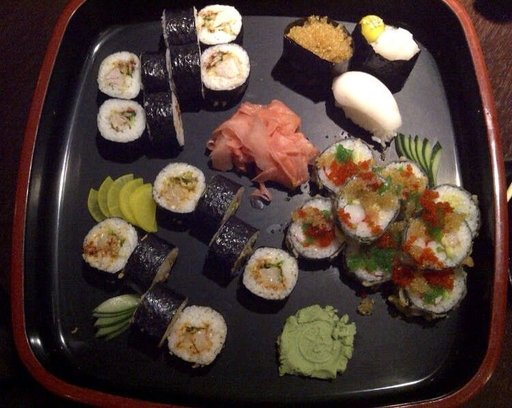

In [131]:
import random
from PIL import Image
random.seed(42)

#Getting all the image paths
image_path_list = list (image_path.glob("*/*/*.jpg")) #Analogous to MySQL, Gives everything

#Picking a random image path -> 
random_image_path = random.choice(image_path_list)


#Getting image class from path name -> 
image_class = random_image_path.parent.stem

#Opening the image -> 
img = Image.open(random_image_path)

#Printing the metadata -> 
print(f"Random image path: {random_image_path}\nImage class: {image_class}\nImage height: {img.height}\nImage width: {img.width}")
img


Text(0.5, 1.0, 'Image class: sushi | Image shape: (408, 512, 3) -> [height, width, color_channels]')

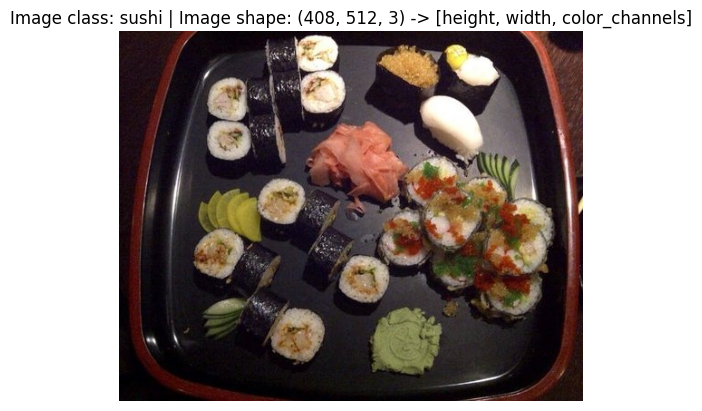

In [132]:
#Plotting using matplotlib for fun

random_image_as_array = np.asarray(img)
plt.imshow(random_image_as_array)
plt.axis(False)
plt.title(f"Image class: {image_class} | Image shape: {random_image_as_array.shape} -> [height, width, color_channels]")

## Transforming Data ->

Before we can use any data in PyTorch -> 
1. Turn your target data into tensors 
    - Example -> Numerical representation for images.

2. Turn it into a `torch.utils.data.Dataset` and subsequently into `torch.utils.data.DataLoader`

In [133]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### Using torchvision.transforms

In [134]:
#Transforms our data by resizing, flipping and turning into Tensor -> 
data_transforms = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.ToTensor()   
    ]
)


In [135]:
data_transforms(img).shape

torch.Size([3, 224, 224])

In [136]:
def plot_transformed_images (image_paths,transforms,n=3,seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig,ax = plt.subplots( nrows=1,ncols=2)
            ax[0].imshow(f)  #Plotting the original image.
            ax[0].set_title(f"Original\nSize = {f.size}")
            ax[0].axis(False)
            
            #Transform and plot the target image 
            transformed_image = transforms(f) #Note we need to change shape.
            ax[1].imshow(transformed_image.permute(1,2,0))
            ax[1].set_title(f"Transformed\nShape = {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class : {image_path.parent.stem}",fontsize=16)
            f.close()
            
            

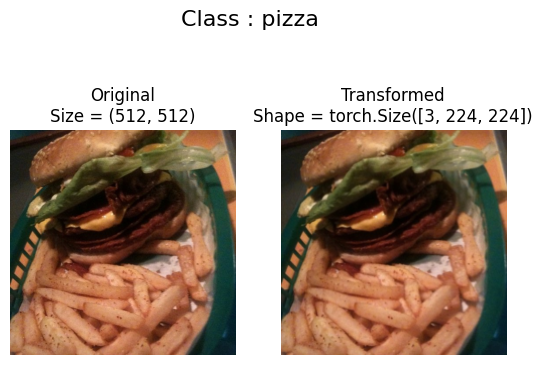

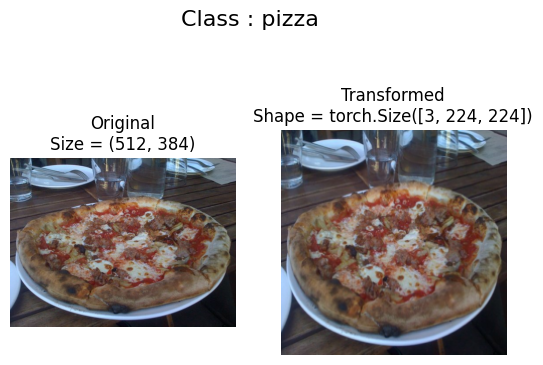

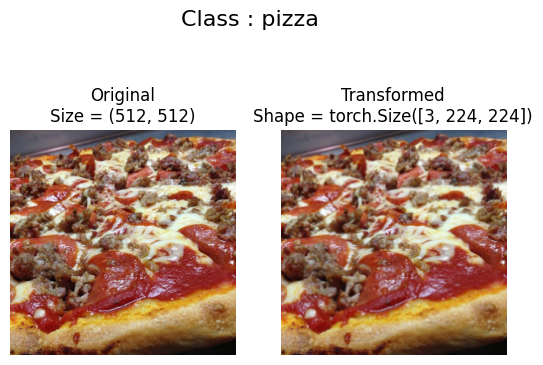

In [137]:
plot_transformed_images(image_paths=image_path_list,
                        transforms=data_transforms,
                        n=3)

#### Loading the image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` 

In [138]:
#Using ImageFolder -> 

train_data = datasets.ImageFolder(root=train_dir, transform=data_transforms, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transforms, target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.3)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.3)
                ToTensor()
            ))

# **Creating a script for data_setup.py**

In [139]:
%%writefile Python_Modules/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

NUM_WORKERS = 0

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=0
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = create_dataloaders(
                             train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Overwriting Python_Modules/data_setup.py


In [140]:
from Python_Modules import data_setup


In [141]:
trdl,tedl,cn = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=data_transforms,batch_size=32)

trdl,tedl,cn 

(<torch.utils.data.dataloader.DataLoader at 0x20fa5c49640>,
 ['pizza', 'steak', 'sushi'])

In [142]:
class_names = train_data.classes
print(class_names)
class_dict = train_data.class_to_idx
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [143]:
len(train_data) , len(test_data)

(225, 75)

In [144]:
train_data.samples[1]

('data\\pizza_steak_sushi\\train\\pizza\\1033251.jpg', 0)

In [145]:

# print(train_data[0])

img,label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [146]:
print(img)

tensor([[[0.1137, 0.1176, 0.1255,  ..., 0.1098, 0.1098, 0.1098],
         [0.1176, 0.1137, 0.1137,  ..., 0.1176, 0.1176, 0.1137],
         [0.1137, 0.1176, 0.1098,  ..., 0.1216, 0.1255, 0.1216],
         ...,
         [0.0941, 0.0902, 0.0863,  ..., 0.1725, 0.1725, 0.1804],
         [0.0902, 0.0902, 0.0902,  ..., 0.1647, 0.1686, 0.1686],
         [0.0863, 0.0863, 0.0824,  ..., 0.1490, 0.1529, 0.1529]],

        [[0.0706, 0.0745, 0.0824,  ..., 0.0549, 0.0549, 0.0549],
         [0.0745, 0.0706, 0.0706,  ..., 0.0627, 0.0627, 0.0588],
         [0.0706, 0.0784, 0.0667,  ..., 0.0627, 0.0667, 0.0627],
         ...,
         [0.1098, 0.1059, 0.1020,  ..., 0.2353, 0.2314, 0.2314],
         [0.1059, 0.1059, 0.1059,  ..., 0.2275, 0.2314, 0.2314],
         [0.1020, 0.1020, 0.0980,  ..., 0.2196, 0.2235, 0.2235]],

        [[0.0941, 0.0980, 0.1059,  ..., 0.0196, 0.0196, 0.0196],
         [0.0980, 0.0941, 0.0941,  ..., 0.0235, 0.0235, 0.0196],
         [0.0941, 0.0980, 0.0902,  ..., 0.0235, 0.0235, 0.

In [147]:
print(f"Label = {label} -> {class_names[label]}")


Label = 0 -> pizza


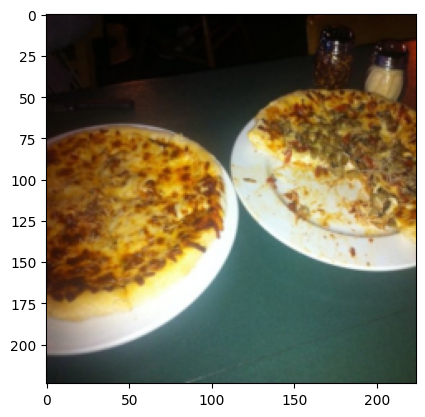

In [148]:
#Plotting using Matplotlib
img_permute=img.permute(1,2,0)
plt.imshow(img_permute)  #Changes shape from [CC,H,W] to [H,W,CC]

### Turning the Train and Test Data into DataLoaders -->

In [149]:
import os
os.cpu_count()

16

In [150]:
BATCH_SIZE=32

train_dataloader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)  
train_dataloader,test_dataloader  

(<torch.utils.data.dataloader.DataLoader at 0x21031e662a0>,
 <torch.utils.data.dataloader.DataLoader at 0x21043cc0710>)

In [151]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [152]:
img,label=next(iter(train_dataloader))

print(f"Original shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")


Original shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


#### Loading Image Data with a Custom Dataset
- Should be able to load images from a file
- Should be able to get classnames from the Dataset
- Should be able to get classes as Dictionary from the Dataset

- Pros of Custom Dataset -> 
    - Can create a `Dataset` out of almost anything
    - Not limited to PyTorch's pre-built `Dataset` Functions

- Cons of Custom Dataset ->
    - Making it work is hard
    - Using a custom `Dataset` relies on writing more code, which can cause performance issues 

In [153]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms 
from typing import List,Tuple,Dict

 

#### Creating a helper function to get class names 

It does the following -> 
- Get the classname using `os.scandir()` to traverse a target directory(Ideally the directory is in standard image classification format)
- Raise an error in case class names are not found(Only when something is wrong with directory structure)
- Turn the class names into a list and a dictionary and return them

In [154]:
#Set up target directory -> 
target_directory =  train_dir
print(f"Target Directory -> {target_directory}")


#Getting the class names from the target directory -> 
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(class_names_found)

Target Directory -> data\pizza_steak_sushi\train
['pizza', 'steak', 'sushi']


In [155]:
def find_classes(directory:str)-> Tuple[List[str],Dict[str,int]]:
    """Find the class folder names in a target directory"""
    
    
    #Getting the class names by scanning the directory using scandir
    classes = sorted([entry.name for entry in list(os.scandir(directory))])
    
    if not classes:
        raise FileNotFoundError(f"Could not find any files in {directory}...\nCheck file structure!")
    
    
    #Creating a dictionary of index labels  
    #We do this because computers prefer numbers as labels rather than strings
    class_to_idx = {class_name : i for i,class_name in enumerate(classes)}
    
    return classes,class_to_idx

In [156]:
find_classes(target_directory)


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

↑ ↑ ↑ ↑ ↑   We just replicated the functionality of ImageFolder() 

## Creating a Custom Dataset => 
- All datasets should subclass `torch.utils.data.Dataset`.
- Init our subclass with a target directory as well as transform.   
- Create several attributes -> 
    - *paths* -> paths for our images.
    - *transform* -> transformation for our images.
    - *classes* -> a list of target classes.
    - *class_to_idx* -> a dict of target class labels mapped to integer labels.
- Create a function to `load_images()` to load the images.
- Overwrite the ``__getitem__()``, which fetches a data sample for a given key/index.
- Overwrite `__len()__` to return the length of our dataset.

In [157]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset): #Subclassing
    
    #Intialising our custom dataset
    def __init__(self,
                 targ_dir:str,
                 transform = None) -> None : 
        
        #Creating several attributes -> 
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        
        #Transform
        self.transform = transform
        
        #Getting classnames and classidx -> 
        self.classes , self.class_to_idx = find_classes(targ_dir)
        
    #Function to load images  
    def load_image(self,index:int)  -> Image.Image:
        """Opens a image via a path and returns it"""
        image_path = self.paths[index] 
        return Image.open(image_path)
    
    #Overwrite the --len()--
    
    def __len__(self):
        """Returns the total number of samples"""
        return len(self.paths)      
    
    #Overwrite __getitem__()  -----> COMPULSORY
    
    def __getitem__(self,index) -> Tuple[torch.Tensor,int]:
        """As our data is like [imageTensor,integerLabel], This function can split it."""
        
        img = self.load_image(index)
        class_name = self.paths[index].parent.name #This excepts the format data/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]
        
        #Transform if needed -> 
        if self.transform: 
            return self.transform(img),class_idx   #Returns data and label
        else:
            return img,class_idx      #Returns untransformed image and label

In [158]:
#Creating data transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.ToTensor()
    ])

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=(64,64)),
        transforms.ToTensor()
    ])

In [159]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x21043d5c4a0>,
 <__main__.ImageFolderCustom at 0x21043ec30e0>)

In [160]:
len(train_data) , len(train_data_custom)

(225, 225)

In [161]:
len(test_data) , len(test_data_custom)

(75, 75)

In [162]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [163]:
#Checking for equality between the ImageFolder dataset and ImageFolderCustom dataset.

print(train_data.classes==train_data_custom.classes)
print(test_data.classes==test_data_custom.classes)

True
True


##### Creating a function to display random images -> 

- Take in a `Dataset` and a number of such parameters like Class names & Image count.
- To prevent the display getting out of our hand, We can put a upper cap of 10 images.
- Random seed for reproducibility.
- Get a list of random sample indexes from the target dataset.
- Loop through the random images and plot them using matplotlib.
- Make sure our image dimensions line up with matplotlib


In [164]:
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str] = None,
                          n:int = 10,
                          display_shape:bool = True,
                          seed:int = None):
    
    #Readjusting display if its too high
    if n>10:
        n=10
        display_shape=False
        print(f"For display, n should not be higher than 10, Setting it to 10 & removing shape display.")
        
    #Set the seed
    if seed:
        random.seed(seed)
        
    #Get random sample indexes -> 
    random_samples_idx = random.sample(range(len(dataset)),k=n)  #Give a list of 10 random indexes b/w 1,len
    
    #Loop through the indexes and plotting -> 
    plt.figure(figsize=(16,8))
    
    for i , targ_sample in enumerate(random_samples_idx):
        targ_image,targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        #Adjusting tensor shapes -> 
        targ_image_permute = targ_image.permute(1,2,0)
        #Plotting -> 
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_permute)
        plt.axis("off")
        
        if classes:
            title = f"Class : {classes[targ_label]}"
        if display_shape:
            title = title  + f"\nShape : {targ_image_permute.shape}"
            
        plt.title(title)

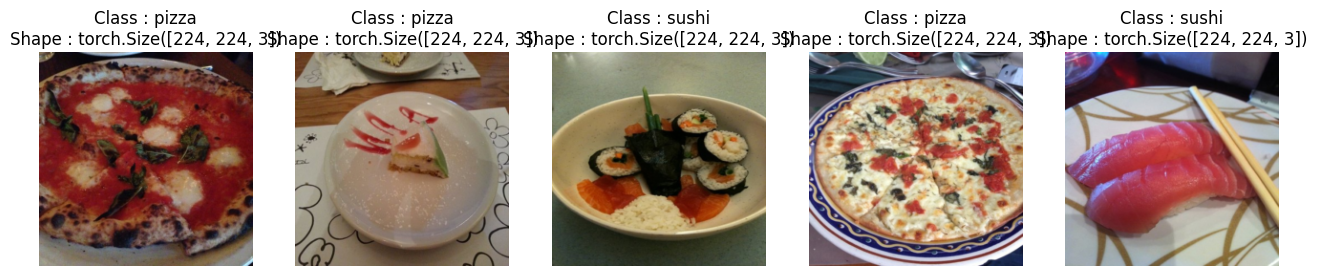

In [165]:
#Random images from ImageFolder Dataset -> 
display_random_images(dataset=train_data,n=5,classes=class_names)

For display, n should not be higher than 10, Setting it to 10 & removing shape display.


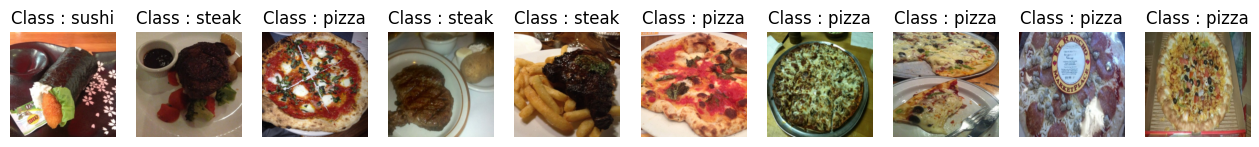

In [166]:
#Random images from ImageFolderCustom Dataset -> 
display_random_images(dataset=train_data_custom,classes=class_names,n=15,seed=None)

# print("Plot would usually work but theres some confusing permission error.")

#### Turning the ImageFolderCustom Datasets into DataLoaders -> 

In [167]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(dataset=train_data_custom,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,batch_size=BATCH_SIZE,shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x21043ef02f0>,
 <torch.utils.data.dataloader.DataLoader at 0x21043ec06b0>)

In [168]:
image_custom , label_custom = next(iter(train_dataloader_custom))

image_custom.shape, label_custom.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#### Other forms of Transformation ( Data Augmentation ) ->
Data Augmentation is the process of artificially adding diversity to your training data.
In layman terms, Its just a bunch of image transformations done to training images. 

In [169]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [170]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:3]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg')]

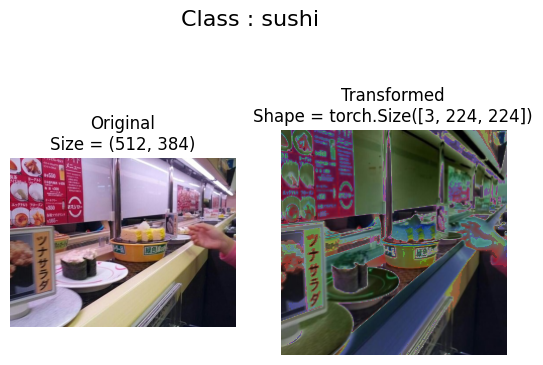

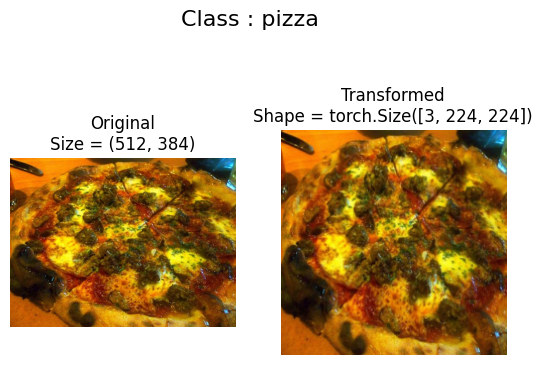

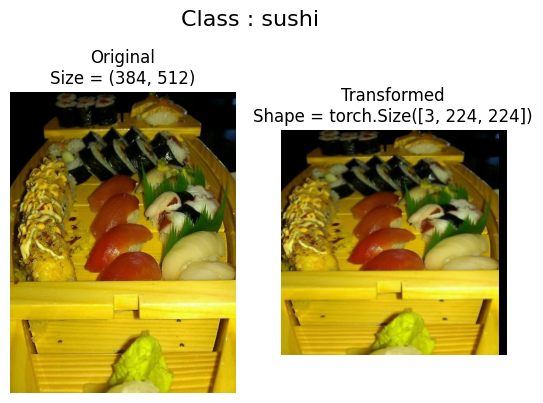

In [171]:
plot_transformed_images(image_paths=image_path_list,transforms=train_transforms,n=3)

### Model 0 -> Tiny VGG Architecture without Data Augmentation -->

Making baseline model which follows the architecture of Small scale TinyVGG from CNN Explainer -> 


In [172]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

train_data_simple = datasets.ImageFolder(root=train_dir,transform=simple_transform,target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir,transform=simple_transform,target_transform=None)

In [173]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS = 0

train_dataloader_simple = DataLoader(dataset=train_data_simple,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True)

In [174]:
INPUT_FEATURES=224*224
HIDDEN_FEATURES=10
OUTPUT_FEATURES=3

class TVGGModel(nn.Module):
    def __init__(self,input_features=INPUT_FEATURES, hidden_features=HIDDEN_FEATURES,output_features=OUTPUT_FEATURES):
        super().__init__()
        
        self.convBlock1 = nn.Sequential(
            
            nn.Conv2d(in_channels=input_features,out_channels=hidden_features,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        
        self.convBlock2 = nn.Sequential(
            
            nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        
        self.classifier  = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(in_features=hidden_features*59*59,out_features=len(class_names))
            
        )
        
    def forward(self,x):
        
        # x=self.convBlock1(x)
        # print(f"conv1 {x.shape}")
        # x=self.convBlock2(x)
        # print(f"conv2 {x.shape}")
        # x=self.classifier(x)
        # print(f"classifier {x.shape}")
        # return x
        
        return self.classifier(self.convBlock2(self.convBlock1(x)))

# **Saving the TinyVGG Model to model.py**

In [175]:
%%writefile Python_Modules/model.py
import torch
import torch.nn as nn

INPUT_FEATURES=224*224
HIDDEN_FEATURES=10
OUTPUT_FEATURES=3

class TVGGModel(nn.Module):
    """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/
  
  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  
    def __init__(self,input_features=INPUT_FEATURES, hidden_features=HIDDEN_FEATURES,output_features=OUTPUT_FEATURES):
        super().__init__()
        
        self.convBlock1 = nn.Sequential(
            
            nn.Conv2d(in_channels=input_features,out_channels=hidden_features,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        
        self.convBlock2 = nn.Sequential(
            
            nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_features,out_channels=hidden_features,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        
        self.classifier  = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(in_features=5776,out_features=OUTPUT_FEATURES)
            
        )
        
    def forward(self,x):
        
        # x=self.convBlock1(x)
        # print(f"conv1 {x.shape}")
        # x=self.convBlock2(x)
        # print(f"conv2 {x.shape}")
        # x=self.classifier(x)
        # print(f"classifier {x.shape}")
        # return x
        
        return self.classifier(self.convBlock2(self.convBlock1(x)))

Overwriting Python_Modules/model.py


In [176]:
from Python_Modules import model

modelFromModule = model.TVGGModel(input_features=3,hidden_features=10,output_features=len(class_names)).to(device)

modelFromModule

TVGGModel(
  (convBlock1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34810, out_features=3, bias=True)
  )
)

In [177]:
model_1=TVGGModel(input_features=3,hidden_features=10,output_features=len(class_names)).to(device)           #Baseline model 

model_1

TVGGModel(
  (convBlock1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34810, out_features=3, bias=True)
  )
)

#### Trying to perform the forward pass on a single image to actually find the factor by which hidden units will be multiplied by in the classfier layer, Also to check if our model works correctly

In [178]:
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch = image_batch.to(device)
label_batch= label_batch.to(device)

In [179]:
model_1(image_batch)

#Initially crashed but then *3481 helped :)

tensor([[ 2.8387e-03, -1.0856e-03, -8.2581e-03],
        [ 1.2167e-03, -8.0525e-04, -5.7840e-03],
        [ 2.6550e-03,  1.2187e-03, -8.3199e-03],
        [ 3.2366e-03, -9.9995e-04, -5.9668e-03],
        [ 2.2873e-03, -6.2383e-04, -6.9930e-03],
        [ 2.1295e-03, -1.1549e-04, -8.1790e-03],
        [ 2.7962e-03, -3.1375e-04, -5.8025e-03],
        [ 3.2390e-03, -1.2338e-03, -6.8598e-03],
        [ 3.5570e-03, -7.1584e-04, -7.7379e-03],
        [ 2.5769e-03, -1.4610e-03, -7.5327e-03],
        [ 2.1266e-03,  5.7420e-05, -7.9530e-03],
        [ 3.2389e-03,  3.9830e-04, -5.5917e-03],
        [ 2.7255e-03, -2.9457e-03, -6.2139e-03],
        [ 3.5237e-03,  5.1083e-04, -5.6228e-03],
        [ 3.1173e-03, -2.1931e-05, -6.2226e-03],
        [ 5.1091e-03, -1.7839e-05, -8.0366e-03],
        [ 2.8396e-03, -1.6665e-03, -5.4805e-03],
        [ 3.1213e-03, -1.3728e-03, -6.9603e-03],
        [ 3.2033e-03,  1.2059e-03, -6.1519e-03],
        [ 2.2472e-03,  8.5500e-04, -6.4855e-03],
        [ 1.6423e-03

Using torchinfo for 

In [180]:
from torchinfo import summary

summary(model=model_1,input_size=[32,3,224,224])


Layer (type:depth-idx)                   Output Shape              Param #
TVGGModel                                [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 114, 114]        --
│    └─Conv2d: 2-1                       [32, 10, 226, 226]        280
│    └─ReLU: 2-2                         [32, 10, 226, 226]        --
│    └─Conv2d: 2-3                       [32, 10, 228, 228]        910
│    └─ReLU: 2-4                         [32, 10, 228, 228]        --
│    └─MaxPool2d: 2-5                    [32, 10, 114, 114]        --
├─Sequential: 1-2                        [32, 10, 59, 59]          --
│    └─Conv2d: 2-6                       [32, 10, 116, 116]        910
│    └─ReLU: 2-7                         [32, 10, 116, 116]        --
│    └─Conv2d: 2-8                       [32, 10, 118, 118]        910
│    └─ReLU: 2-9                         [32, 10, 118, 118]        --
│    └─MaxPool2d: 2-10                   [32, 10, 59, 59]          --
├─Sequentia

### Creating training and testing loop functions -> 

In [181]:
from torchmetrics.classification import Accuracy
accuracy_fn = Accuracy(task="multiclass",num_classes=len(class_names)).to(device)

In [182]:
#Similar to 04 File, We will write train_step() and test_step()

def training_step(model:torch.nn.Module,
                  dataloader:torch.utils.data.DataLoader,
                  loss_fn:torch.nn.Module,
                  optimizer:torch.optim.Optimizer):
    
    model.train()
    
    training_loss,training_accuracy = 0,0
    
    for batch, (X,y) in enumerate(dataloader):
        
        X=X.to(device) 
        y=y.to(device)
        
        
        y_prediction= model(X)
        
        
        batchLoss=loss_fn(y_prediction,y)
        training_loss+=batchLoss
        training_accuracy+= accuracy_fn(torch.softmax(y_prediction,dim=1).argmax(dim = 1),y)
        
        
        optimizer.zero_grad()
        
        
        batchLoss.backward()
        
        
        optimizer.step()
        
        
    #Avg training loss and accuracy per batch.
    training_loss/=len(dataloader)
    training_accuracy/=len(dataloader)
    
    
    return training_loss,training_accuracy

In [183]:
def testing_step(model: torch.nn.Module,
                 loss_fn: torch.nn.Module,
                 dataloader: torch.utils.data.DataLoader):
    
    model.eval()  # Set the model to evaluation mode
    test_loss, test_acc = 0, 0  # Initialize loss and accuracy
    
    # Disable gradient calculation for efficiency during evaluation
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()/len(dataloader)
            
            # Calculate and accumulate accuracy
            test_acc+= accuracy_fn(torch.softmax(test_pred_logits,dim=1).argmax(dim = 1),y)/len(dataloader)
            
    # Adjust metrics to get average loss and accuracy per batch 
    # test_loss = test_loss / len(dataloader)
    # test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [184]:
from tqdm.auto import tqdm

In [185]:
def train_n_test(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):
    
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch} -> \n -----------")
        
        train_loss,train_acc= training_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer)
        test_loss,test_acc= testing_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn)
        
        print(f"Training Loss : {train_loss:.4f} | Training Accuracy : {train_acc*100:.7f} | Testing Loss : {test_loss:.4f} | Testing Accuracy :{test_acc*100:.7f}")
        
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    
    return results

# **Making a engine.py script for testing,training and result tracking**

In [230]:
%%writefile Python_Modules/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
from typing import Dict, List, Tuple

import torch

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc*100:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc*100:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Overwriting Python_Modules/engine.py


In [187]:
from Python_Modules import engine

### Training and Evalutating Baseline Model -> 

In [188]:
from timeit import default_timer as timer


In [189]:
NUM_EPOCHS = 10

model_1 = TVGGModel(input_features=3,      #Number of colour channels 
                    hidden_features=10,
                    output_features=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_1.parameters(), lr = 0.001)
# optimizer = torch.optim.RMSprop(params=model_1.parameters(),lr=0.01)

startTime = timer()

#Training the model 

model_1_results = train_n_test(model=model_1,train_dataloader=train_dataloader_simple,test_dataloader=test_dataloader_simple,optimizer=optimizer,loss_fn=loss_fn,epochs=NUM_EPOCHS)

endTime = timer()
totalTrainTimeModel1=endTime-startTime
print(f"Total time to train model 1 -> {totalTrainTimeModel1} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 -> 
 -----------


 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

Training Loss : 1.1953 | Training Accuracy : 42.9687500 | Testing Loss : 1.2847 | Testing Accuracy :25.7575760
Epoch 1 -> 
 -----------


 20%|██        | 2/10 [00:02<00:08,  1.06s/it]

Training Loss : 1.1117 | Training Accuracy : 40.6250000 | Testing Loss : 1.0705 | Testing Accuracy :37.9734879
Epoch 2 -> 
 -----------


 30%|███       | 3/10 [00:03<00:07,  1.05s/it]

Training Loss : 1.1246 | Training Accuracy : 30.4687500 | Testing Loss : 1.1054 | Testing Accuracy :30.0189400
Epoch 3 -> 
 -----------


 40%|████      | 4/10 [00:04<00:06,  1.09s/it]

Training Loss : 1.1156 | Training Accuracy : 31.2500000 | Testing Loss : 1.0794 | Testing Accuracy :39.2045479
Epoch 4 -> 
 -----------


 50%|█████     | 5/10 [00:05<00:05,  1.10s/it]

Training Loss : 1.0735 | Training Accuracy : 50.0000000 | Testing Loss : 1.0959 | Testing Accuracy :30.8712120
Epoch 5 -> 
 -----------


 60%|██████    | 6/10 [00:06<00:04,  1.09s/it]

Training Loss : 1.0390 | Training Accuracy : 44.1406250 | Testing Loss : 1.1050 | Testing Accuracy :25.7575760
Epoch 6 -> 
 -----------


 70%|███████   | 7/10 [00:07<00:03,  1.07s/it]

Training Loss : 0.9935 | Training Accuracy : 41.7968750 | Testing Loss : 1.0981 | Testing Accuracy :27.9356060
Epoch 7 -> 
 -----------


 80%|████████  | 8/10 [00:08<00:02,  1.06s/it]

Training Loss : 1.0160 | Training Accuracy : 40.6250000 | Testing Loss : 1.0869 | Testing Accuracy :38.2575798
Epoch 8 -> 
 -----------


 90%|█████████ | 9/10 [00:09<00:01,  1.06s/it]

Training Loss : 0.8845 | Training Accuracy : 66.7968750 | Testing Loss : 1.0872 | Testing Accuracy :41.1931839
Epoch 9 -> 
 -----------


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

Training Loss : 0.9108 | Training Accuracy : 60.9375000 | Testing Loss : 0.9977 | Testing Accuracy :50.3787880
Total time to train model 1 -> 10.707057900000109 seconds


The output is not the best.

In [190]:
model_1_results

{'train_loss': [1.1952927112579346,
  1.1117289066314697,
  1.124560832977295,
  1.1155728101730347,
  1.073454737663269,
  1.0389833450317383,
  0.9935471415519714,
  1.0159714221954346,
  0.8844736218452454,
  0.9108279943466187],
 'train_acc': [0.4296875,
  0.40625,
  0.3046875,
  0.3125,
  0.5,
  0.44140625,
  0.41796875,
  0.40625,
  0.66796875,
  0.609375],
 'test_loss': [1.2847376664479575,
  1.0705172220865886,
  1.105387290318807,
  1.079438885052999,
  1.0959459940592449,
  1.1049964427947998,
  1.0981009006500244,
  1.0869023005167642,
  1.0872058471043906,
  0.9977131883303325],
 'test_acc': [0.25757575035095215,
  0.3797348737716675,
  0.30018940567970276,
  0.3920454680919647,
  0.3087121248245239,
  0.25757575035095215,
  0.27935606241226196,
  0.38257578015327454,
  0.4119318425655365,
  0.5037878751754761]}

##### Plotting the **Loss Curve**
A loss curve is a way of tracking a model's progress over time/epochs.

In [191]:
model_1_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [192]:
def plot_loss_curves(results : Dict[str, List[float]]):
    #This function plots the loss curves for a model's results.
     
    loss = results["train_loss"]
    test_loss = results["test_loss"]
     
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]    
     
    epochs = range(len(results["train_loss"]))
    
    plt.figure(figsize=(16,6))
    
    #Plotting the loss
    plt.subplot(1,2,1)
    plt.plot(epochs,loss, label = "Training Loss")
    plt.plot(epochs,test_loss, label = "Testing Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    #Plotting the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,accuracy, label = "Training Accuracy")
    plt.plot(epochs,test_accuracy, label = "Testing Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    

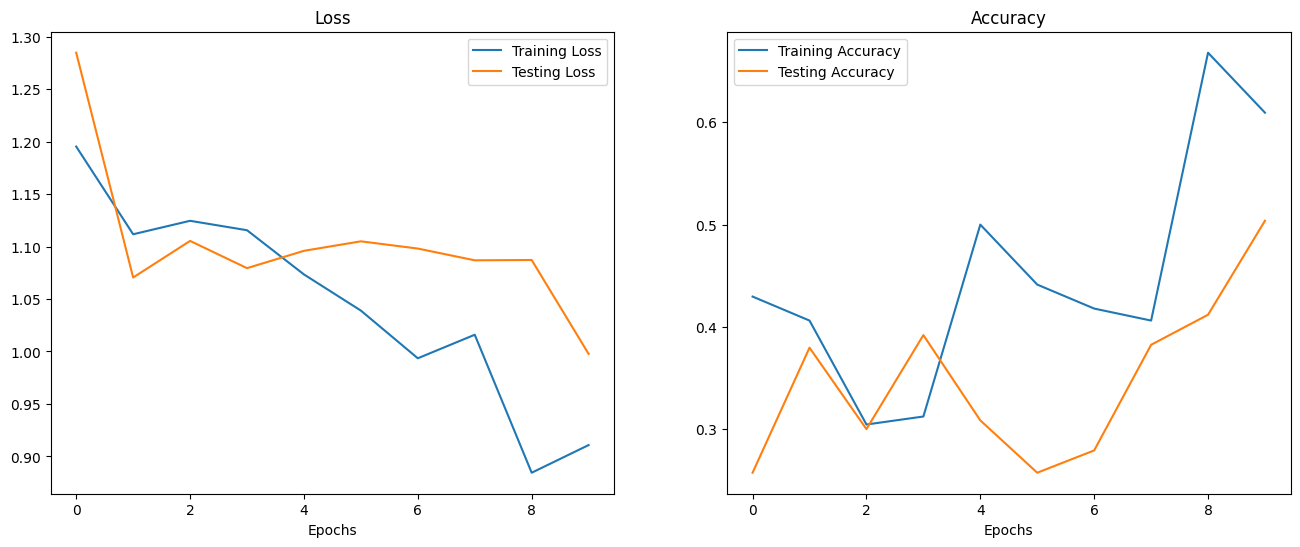

In [193]:
plot_loss_curves(results=model_1_results)

More about loss curves -> https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

#### Loss Curve Classifications ->
- Underfitting -> The loss in general for both training and testing can be lower.
- Overfitting -> Model performs very good on the training dataset by learning its patterns but fails to do so on the testing dataset.
- Best fit -> The performance on both training and testing datasets is about the same and loss is low. 

##### Some ways to reduce **Overfitting** ->

| Method to prevent overfitting |                                                                                                                                                                   What is it?                                                                                                                                                                  |
|:-----------------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Get more data                 | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.                                                                                                                                                                                                               |
| Simplify your model           | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. |
| Use data augmentation         | Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.                                                                          |
| Use transfer learning         | Transfer learning involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.                           |
| Use dropout layers            | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See torch.nn.Dropout() for more.                                                                                                                                        |
| Use learning rate decay       | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to convergence, the smaller you'll want your weight updates to be.                                        |
| Use early stopping            | Early stopping stops model training before it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior).                                                  |

##### Some ways to prevent **Underfitting** -> 


|    Method to prevent underfitting   |                                                                                                                                   What is it?                                                                                                                                  |
|:-----------------------------------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Add more layers/units to your model | If your model is underfitting, it may not have enough capability to learn the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. |
| Tweak the learning rate             | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens.                                                  |
| Use transfer learning               | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem.                                                                                                |
| Train for longer                    | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance.                                              |
| Use less regularization             | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better.                                                                                                   |                                                                       

### TVGGModel with Data Augmentation -> 

In [194]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [195]:
torch.manual_seed(8888)
torch.cuda.manual_seed(8888)
train_data_augmented = datasets.ImageFolder(root=train_dir,transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,transform=test_transform_simple,)

test_data_simple

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [196]:
BATCH_SIZE=32
NUM_WORKERS=0

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,batch_size=BATCH_SIZE,)
test_dataloader_simple = DataLoader(dataset=test_data_simple,batch_size=BATCH_SIZE)

In [197]:
model_2 = TVGGModel(input_features=3,hidden_features=10,output_features=len(class_names)).to(device)
model_2

TVGGModel(
  (convBlock1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34810, out_features=3, bias=True)
  )
)

In [198]:
from torchinfo import summary

summary(model=model_2,input_size=[32,3,224,224])


Layer (type:depth-idx)                   Output Shape              Param #
TVGGModel                                [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 114, 114]        --
│    └─Conv2d: 2-1                       [32, 10, 226, 226]        280
│    └─ReLU: 2-2                         [32, 10, 226, 226]        --
│    └─Conv2d: 2-3                       [32, 10, 228, 228]        910
│    └─ReLU: 2-4                         [32, 10, 228, 228]        --
│    └─MaxPool2d: 2-5                    [32, 10, 114, 114]        --
├─Sequential: 1-2                        [32, 10, 59, 59]          --
│    └─Conv2d: 2-6                       [32, 10, 116, 116]        910
│    └─ReLU: 2-7                         [32, 10, 116, 116]        --
│    └─Conv2d: 2-8                       [32, 10, 118, 118]        910
│    └─ReLU: 2-9                         [32, 10, 118, 118]        --
│    └─MaxPool2d: 2-10                   [32, 10, 59, 59]          --
├─Sequentia

In [199]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),lr=0.001)

In [200]:
NUM_EPOCHS=10

startTime=timer()

model_2_results = train_n_test(model=model_2,train_dataloader=train_dataloader_augmented,test_dataloader=test_dataloader_simple,optimizer=optimizer,loss_fn=loss_fn,epochs=NUM_EPOCHS)

endTime=timer()
totalTrainTimeModel2=endTime-startTime
print(f"Total Time taken by model_2 -> {totalTrainTimeModel2} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 -> 
 -----------


 10%|█         | 1/10 [00:01<00:10,  1.15s/it]

Training Loss : 2.7908 | Training Accuracy : 17.9687500 | Testing Loss : 1.6386 | Testing Accuracy :19.7916679
Epoch 1 -> 
 -----------


 20%|██        | 2/10 [00:02<00:09,  1.13s/it]

Training Loss : 1.0723 | Training Accuracy : 47.2656250 | Testing Loss : 1.1527 | Testing Accuracy :54.1666679
Epoch 2 -> 
 -----------


 30%|███       | 3/10 [00:03<00:07,  1.14s/it]

Training Loss : 1.4674 | Training Accuracy : 40.2343750 | Testing Loss : 1.0382 | Testing Accuracy :54.1666679
Epoch 3 -> 
 -----------


 40%|████      | 4/10 [00:04<00:06,  1.13s/it]

Training Loss : 1.1557 | Training Accuracy : 40.2343750 | Testing Loss : 1.0785 | Testing Accuracy :54.1666679
Epoch 4 -> 
 -----------


 50%|█████     | 5/10 [00:05<00:05,  1.16s/it]

Training Loss : 1.1009 | Training Accuracy : 30.8593750 | Testing Loss : 1.0844 | Testing Accuracy :51.1363640
Epoch 5 -> 
 -----------


 60%|██████    | 6/10 [00:06<00:04,  1.15s/it]

Training Loss : 1.0923 | Training Accuracy : 35.9375000 | Testing Loss : 1.0786 | Testing Accuracy :54.1666679
Epoch 6 -> 
 -----------


 70%|███████   | 7/10 [00:07<00:03,  1.14s/it]

Training Loss : 1.0838 | Training Accuracy : 40.2343750 | Testing Loss : 1.0688 | Testing Accuracy :54.1666679
Epoch 7 -> 
 -----------


 80%|████████  | 8/10 [00:09<00:02,  1.15s/it]

Training Loss : 1.0734 | Training Accuracy : 40.2343750 | Testing Loss : 1.0589 | Testing Accuracy :54.1666679
Epoch 8 -> 
 -----------


 90%|█████████ | 9/10 [00:10<00:01,  1.16s/it]

Training Loss : 1.0648 | Training Accuracy : 40.2343750 | Testing Loss : 1.0471 | Testing Accuracy :54.1666679
Epoch 9 -> 
 -----------


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

Training Loss : 1.0626 | Training Accuracy : 40.2343750 | Testing Loss : 1.0451 | Testing Accuracy :54.1666679
Total Time taken by model_2 -> 11.50724050000008 seconds


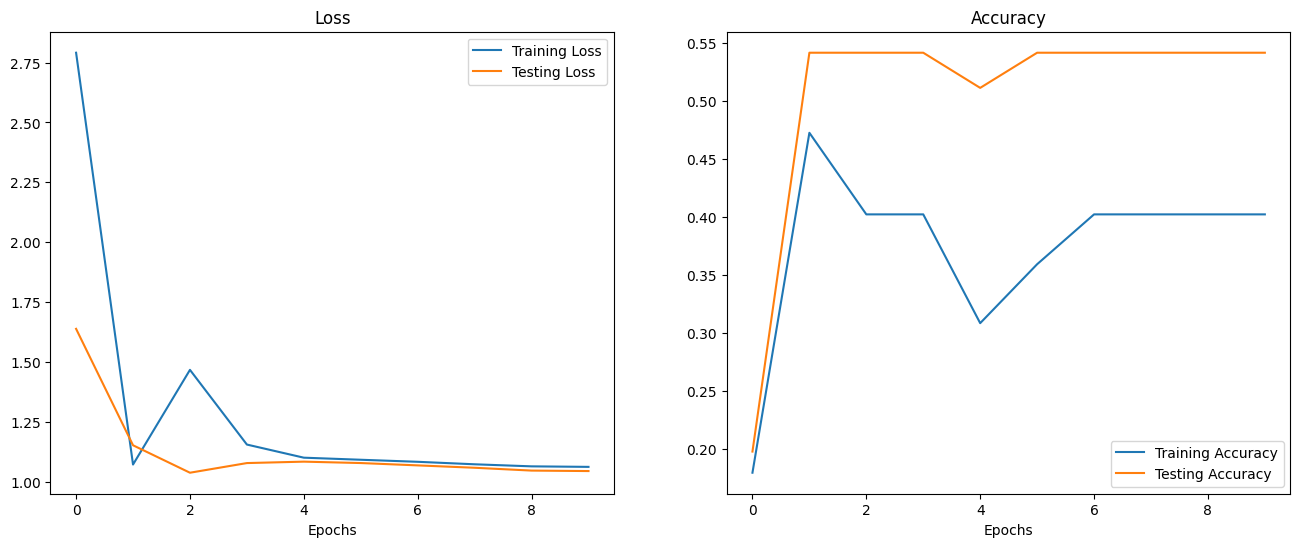

In [201]:
plot_loss_curves(results=model_2_results)

#### Comparing Model Results -> 

There are a few ways to do this -> 
1. Hard Coding 
2. PyTorch + TensorBoard 
3. Weights & Biases     
4. MLflow


In [202]:
#Comparing model results after evaluation is important -> 
import pandas as pd
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)
model_1_df

train_loss  train_acc  test_loss  test_acc
0    1.195293   0.429688   1.284738  0.257576
1    1.111729   0.406250   1.070517  0.379735
2    1.124561   0.304688   1.105387  0.300189
3    1.115573   0.312500   1.079439  0.392045
4    1.073455   0.500000   1.095946  0.308712
5    1.038983   0.441406   1.104996  0.257576
6    0.993547   0.417969   1.098101  0.279356
7    1.015971   0.406250   1.086902  0.382576
8    0.884474   0.667969   1.087206  0.411932
9    0.910828   0.609375   0.997713  0.503788

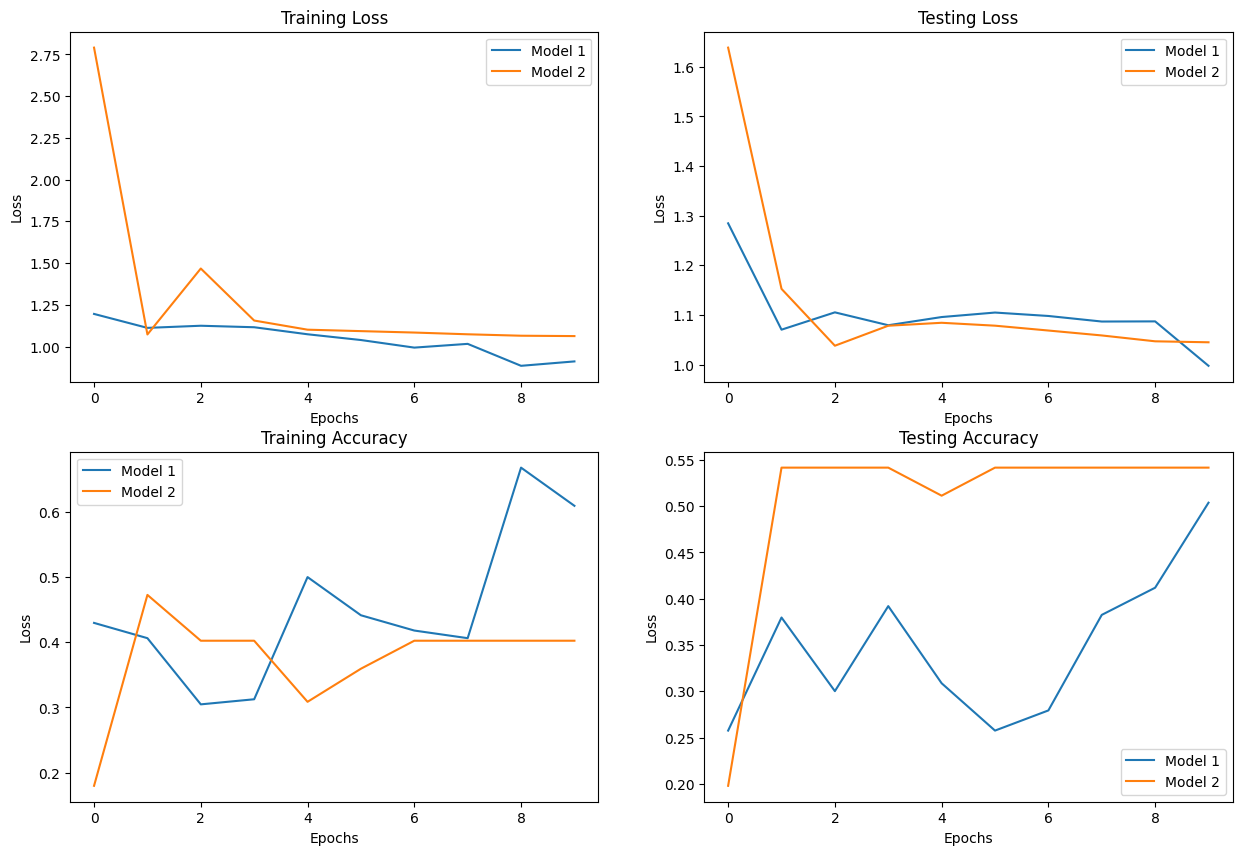

In [203]:
plt.figure(figsize=(15,10))

epochs = range(len(model_1_df))

#Plotting training loss --> 
plt.subplot(2,2,1)
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.plot(epochs,model_2_df["train_loss"],label="Model 2")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#Plotting testing  loss --> 
plt.subplot(2,2,2)
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.plot(epochs,model_2_df["test_loss"],label="Model 2")
plt.title("Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#Plotting Training Accuracy --> 
plt.subplot(2,2,3)
plt.plot(epochs,model_1_df["train_acc"],label="Model 1")
plt.plot(epochs,model_2_df["train_acc"],label="Model 2")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#Plotting Testing Accuracy --> 
plt.subplot(2,2,4)
plt.plot(epochs,model_1_df["test_acc"],label="Model 1")
plt.plot(epochs,model_2_df["test_acc"],label="Model 2")
plt.title("Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Making a prediction on a custom sample -> 

We have done the training and testing, Now we will test the model on our own image thats neither in test or train dataset.

In [204]:
import requests 

custom_image_path = datapath/"random-image.jpg"

if not custom_image_path.is_file():
    with open(custom_image_path,"wb") as f:
        
        request = requests.get("https://everydayglutenfreegourmet.ca/wp-content/uploads/2023/07/handmade-sushi-rolls.jpg")
        f.write(request.content)
        print("Downloaded the file!")
else:
    print(f"The file already exists!")

The file already exists!


Right now the image is in jpg format, We have to turn it into the exact data form that our model was trained on.

- Torch.Float32 Tensor
- 224 x 224 x 3
- On "Device"

In [205]:
import torchvision 

#Reading the image using torchvision.io.read_image
#This turns the image from jpeg or png to uint8 tensor [0,255]-> 

custom_image_uint8 =torchvision.io.read_image(custom_image_path)

In [206]:
custom_image_uint8

tensor([[[ 21,  21,  21,  ..., 124, 124, 124],
         [ 21,  21,  21,  ..., 125, 125, 125],
         [ 21,  21,  21,  ..., 125, 125, 125],
         ...,
         [ 41,  43,  45,  ...,  12,  10,   9],
         [ 41,  43,  45,  ...,  12,  10,   8],
         [ 40,  42,  44,  ...,  12,  10,   7]],

        [[  1,   1,   1,  ...,  97,  97,  97],
         [  1,   1,   1,  ...,  98,  98,  98],
         [  1,   1,   1,  ...,  98,  98,  98],
         ...,
         [ 23,  25,  26,  ...,  11,   9,   8],
         [ 22,  24,  26,  ...,  11,   9,   7],
         [ 21,  23,  25,  ...,  11,   9,   6]],

        [[  2,   2,   2,  ...,  80,  80,  80],
         [  2,   2,   2,  ...,  81,  81,  81],
         [  2,   2,   2,  ...,  81,  81,  81],
         ...,
         [ 19,  21,  22,  ...,  25,  23,  22],
         [ 18,  20,  22,  ...,  25,  23,  21],
         [ 17,  19,  21,  ...,  25,  23,  20]]], dtype=torch.uint8)

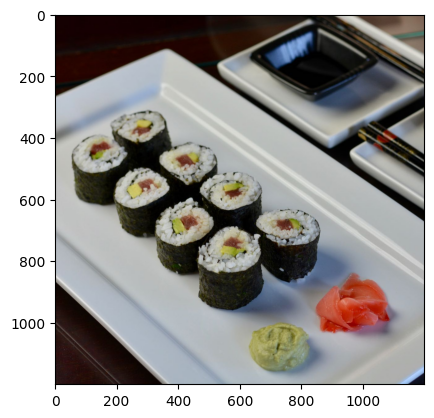

In [207]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [208]:
#Changing the datatype, resolution and the device of the image ->
custom_image_float32=custom_image_uint8.type(torch.float)
# custom_image_float32.dtype
custom_image_float32=custom_image_float32.to(device)
# custom_image_float32.device

#As still the image values are between 0 - 255 and not 0 - 1 like previous -> 
custom_image_float32/=255.
print(custom_image_float32)

custom_transform = transforms.Compose([
    transforms.Resize(size=(224,224))
])

tensor([[[0.0824, 0.0824, 0.0824,  ..., 0.4863, 0.4863, 0.4863],
         [0.0824, 0.0824, 0.0824,  ..., 0.4902, 0.4902, 0.4902],
         [0.0824, 0.0824, 0.0824,  ..., 0.4902, 0.4902, 0.4902],
         ...,
         [0.1608, 0.1686, 0.1765,  ..., 0.0471, 0.0392, 0.0353],
         [0.1608, 0.1686, 0.1765,  ..., 0.0471, 0.0392, 0.0314],
         [0.1569, 0.1647, 0.1725,  ..., 0.0471, 0.0392, 0.0275]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.3804, 0.3804, 0.3804],
         [0.0039, 0.0039, 0.0039,  ..., 0.3843, 0.3843, 0.3843],
         [0.0039, 0.0039, 0.0039,  ..., 0.3843, 0.3843, 0.3843],
         ...,
         [0.0902, 0.0980, 0.1020,  ..., 0.0431, 0.0353, 0.0314],
         [0.0863, 0.0941, 0.1020,  ..., 0.0431, 0.0353, 0.0275],
         [0.0824, 0.0902, 0.0980,  ..., 0.0431, 0.0353, 0.0235]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.3137, 0.3137, 0.3137],
         [0.0078, 0.0078, 0.0078,  ..., 0.3176, 0.3176, 0.3176],
         [0.0078, 0.0078, 0.0078,  ..., 0.3176, 0.3176, 0.

In [209]:
custom_image_transformed = custom_transform(custom_image_float32)

custom_image_transformed.shape

torch.Size([3, 224, 224])

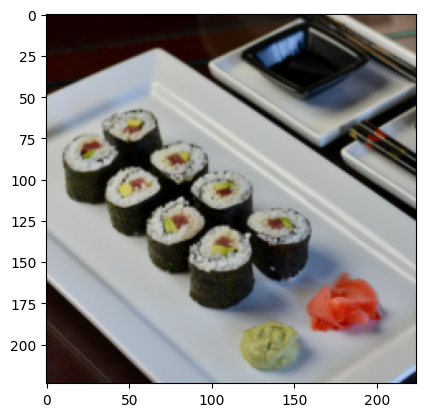

In [210]:
plt.imshow(custom_image_transformed.permute(1,2,0).cpu())

In [211]:

model_2.eval()

# with torch.inference_mode():
    # custom_image_prediction = model_2(custom_image_transformed)
    
# This will error as there is no batch size ^

TVGGModel(
  (convBlock1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34810, out_features=3, bias=True)
  )
)

In [212]:
custom_image_transformed.unsqueeze(dim=0).shape

torch.Size([1, 3, 224, 224])

In [213]:
custom_image_transformed=custom_image_transformed.unsqueeze(dim=0)
with torch.inference_mode():
    custom_image_prediction = model_2(custom_image_transformed)

In [214]:
custom_image_predicted_label = torch.argmax(torch.softmax(custom_image_prediction,dim=1),dim=1)

print(class_names[custom_image_predicted_label.item()])

sushi


##### Functionising the above code to predict random images -> 

In [215]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_url:str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device,
                        image_path: str =None):
    #Makes a prediction on a target image and plots the image with its prediction.
    
    image_path = datapath/"random-image.jpg"

    if not image_path.is_file():
        with open(custom_image_path,"wb") as f:
        
            request = requests.get(str(image_url))
            f.write(request.content)
            print("Downloaded the file!")
    else:
        print(f"The file already exists!")
    
    #Load in image and convert the tensor values to float32 & get them between 0 and 1
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)/ 255. 
    
    #Transform 
    if transform:
        target_image = transform(target_image)
    

    model.eval()
    with torch.inference_mode():
        
        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))
        
    #Getting prediction labels -> 
    target_image_pred_probs = torch.softmax(target_image_pred,dim=1)
    target_image_pred_label =torch.argmax(torch.softmax(target_image_pred,dim=1),dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

The file already exists!


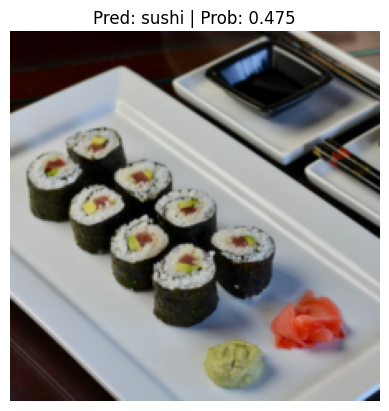

In [216]:
pred_and_plot_image(model=model_1,class_names=class_names,transform=custom_transform,image_url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTtTm0Bb-OL1glJygTK2WNELnGBVDKf3-OErg&s")

In [217]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [218]:
save_model(model=model_2,target_dir="models",model_name="model2.pth")

[INFO] Saving model to: models\model2.pth


In [219]:
save_model(model=model_2,target_dir="models",model_name="model1.pth")

[INFO] Saving model to: models\model1.pth


# **Creating a utils.py file for utility function**

In [247]:
%%writefile Python_Modules/utils.py
"""This file can have more utility functions too, Rn has only save_model()"""

from pathlib import Path
import torch

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path) 

Overwriting Python_Modules/utils.py


In [221]:
train_dir = "06_PyTorch_Going_Modular/data/pizza_steak_sushi/train"
test_dir = "06_PyTorch_Going_Modular/data/pizza_steak_sushi/test"

# **Training evalutating and saving the model -> train.py**

Trying to write all the function calling in one line.

In [244]:
%%writefile Python_Modules/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
from torchvision import transforms
import data_setup, engine, model, utils
from timeit import Timer as timer
import multiprocessing


# Setup hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 16
HIDDEN_UNITS = 16
LEARNING_RATE = 0.001

# Setup directories
train_dir = r"F:\AI\PyTorch from FreeCodeCamp\05_0_PyTorch_Custom_Datasets\data\pizza_steak_sushi\train"
test_dir =  r"F:\AI\PyTorch from FreeCodeCamp\05_0_PyTorch_Custom_Datasets\data\pizza_steak_sushi\test"




# Setup target device
# device = "cuda"
# print(f"[INFO] Using device: {device}")

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])


# Create DataLoaders

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)


# Create model

model = model.TVGGModel(
    input_features=3,
    hidden_features=HIDDEN_UNITS,
    output_features=len(class_names)
)


# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Start training

results = engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS)


# Save the model
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")



Overwriting Python_Modules/train.py


In [245]:
!python Python_Modules/train.py 

Epoch: 1 | train_loss: 1.1093 | train_acc: 27.9167 | test_loss: 1.0982 | test_acc: 31.2500
Epoch: 2 | train_loss: 1.0973 | train_acc: 38.3333 | test_loss: 1.1100 | test_acc: 30.0000
Epoch: 3 | train_loss: 1.1010 | train_acc: 39.5833 | test_loss: 1.1001 | test_acc: 38.7500
Epoch: 4 | train_loss: 1.0473 | train_acc: 38.7500 | test_loss: 1.1126 | test_acc: 37.2727
Epoch: 5 | train_loss: 0.9452 | train_acc: 59.1667 | test_loss: 1.0134 | test_acc: 33.6364
Epoch: 6 | train_loss: 0.8481 | train_acc: 63.7500 | test_loss: 0.9615 | test_acc: 55.0000
Epoch: 7 | train_loss: 0.7827 | train_acc: 67.9167 | test_loss: 1.0305 | test_acc: 41.8182
Epoch: 8 | train_loss: 0.7727 | train_acc: 62.0833 | test_loss: 1.0203 | test_acc: 49.0909
Epoch: 9 | train_loss: 0.7343 | train_acc: 67.5000 | test_loss: 1.0323 | test_acc: 53.4091
Epoch: 10 | train_loss: 0.6817 | train_acc: 62.9167 | test_loss: 0.9888 | test_acc: 54.4318
Epoch: 11 | train_loss: 0.6560 | train_acc: 72.0833 | test_loss: 1.0388 | test_acc: 47.38


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
